In [1]:
# Import Libraries
import numpy as np
import torch
import torchvision.transforms as tvt
import torch.utils.data 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import os
import seaborn as sns
from torchvision.ops import complete_box_iou_loss
import pandas as pd
import cv2
import json
from pprint import pprint
from torchinfo import summary

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

/home/dfarache/.conda/envs/cent7/2020.11-py38/eceDL2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GLOBAL VARIABLES
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Torch is on {device}")
device = torch.device(device)
path_to_model = r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw06/model/model.pth"
class_list = ["bus", "cat", "pizza"]
inverse_categories = {0: "bus", 1: "cat", 2: "pizza"}
image_size = 256 # wxh = 256x256
batch_size = 2
num_anchor_boxes = 5 # (height/width)   1/5  1/3  1/1  3/1  5/1  aspect ratios
max_num_objects = 3
yolo_vector_size = 8
yolo_interval = 42 # Each cell is 42x42 pixels
num_cells_image_width = image_size // yolo_interval
num_cells_image_height = image_size // yolo_interval
num_yolo_cells = num_cells_image_width * num_cells_image_height # Create a grid of cells overlaying the image

Torch is on cuda


## Generate Datasets

In [22]:
def get_bbox_from_tensor(cell_row_index, cell_col_index, predicted_regression_vector):
    del_x,del_y = predicted_regression_vector[0], predicted_regression_vector[1]
    h,w = predicted_regression_vector[2], predicted_regression_vector[3]
    h *= yolo_interval
    w *= yolo_interval       
    
    bbox_center_x_coord = cell_col_index * yolo_interval  +  yolo_interval/2  +  del_x * yolo_interval
    bbox_center_y_coord = cell_row_index * yolo_interval  +  yolo_interval/2  +  del_y * yolo_interval
    x1 =  int(bbox_center_x_coord - w / 2.0)
    y1 =  int(bbox_center_y_coord - h / 2.0)
    
    return [x1, y1, int(w + x1), int(h + y1)]

In [29]:
def create_yolo_tensor(image, bboxs, labels, num_images_in_batch=1, visualize=False):
    # Inspired by Professor Kak's run_code_for_training_multi_instance_detection function
    height_center_bb = torch.zeros(num_images_in_batch, 1).float()
    width_center_bb = torch.zeros(num_images_in_batch, 1).float()
    object_bb_height = torch.zeros(num_images_in_batch, 1).float()
    object_bb_width = torch.zeros(num_images_in_batch, 1).float()
    yolo_tensor = torch.zeros(num_yolo_cells, num_anchor_boxes, yolo_vector_size)
    
    valid_anchor_box_idx = []
    valid_yolo_cell_idx = []
    
    assert max_num_objects == len(bboxs) == len(labels)
    # jdx represents the index of the object in the foreground of the image
    for jdx in range(max_num_objects):        
        object_center_y_coord = (bboxs[jdx, 1].float() + bboxs[jdx, 3].float()) / 2.0 # Just check the batch and iterate through each bbox for y1 and y2
        height_center_bb = object_center_y_coord.int()

        object_center_x_coord = (bboxs[jdx, 0].float() + bboxs[jdx, 2].float()) / 2.0 # Just check the batch and iterate through each bbox for x1 and x2
        width_center_bb = object_center_x_coord.int()

        object_bb_height = bboxs[jdx, 3] - bboxs[jdx, 1] # Height of the bounding box 
        object_bb_width = bboxs[jdx, 2] - bboxs[jdx, 0] # Width of the bounding box
        
        if(object_bb_height < 4.0 or object_bb_width < 4.0):
            # Disregard bounding boxes that have a height or width of less than an arbitrary number 4
            continue

        # Get the cell row and column index that corresponds to the center of the bounding box 
        cell_row_idx = torch.clamp((height_center_bb / yolo_interval).int(), max=num_cells_image_height - 1) 
        cell_col_idx = torch.clamp((width_center_bb / yolo_interval).int(), max=num_cells_image_width - 1) 

        ### Get the height of the bounding box divided by the actual height of the cell
        bh = object_bb_height.float() / yolo_interval
        bw = object_bb_width.float() / yolo_interval

        ### Calculate del_x and del_y 
        # del_x is the x_coordinate displacement from the center of the bbox and the center of the cell
        # del_y is the y_coordinate displacement from the center of the bbox and the center of the cell
        
        # Calculate the center of the cell (i,j) coordinates
        cell_center_i = cell_row_idx * yolo_interval + float(yolo_interval) / 2.0
        cell_center_j = cell_col_idx * yolo_interval + float(yolo_interval) / 2.0

        # Compute del_x and del_y
        del_x = (object_center_x_coord.float() - cell_center_j.float()) / yolo_interval
        del_y = (object_center_y_coord.float() - cell_center_i.float()) / yolo_interval

        ### Get the class label
        class_label_of_object = int(labels[jdx].item())
        if(class_label_of_object == 13):
            # Disregard labels with class label 13
            continue
        
        ### Get Aspect Ratio
        aspect_ratio = object_bb_height.float() / object_bb_width.float()
        anchor_box_idx = 0
        if aspect_ratio <= 0.2:               anchor_box_idx = 0                                                     ## (45)
        if 0.2 < aspect_ratio <= 0.5:         anchor_box_idx = 1                                                     ## (46)
        if 0.5 < aspect_ratio <= 1.5:         anchor_box_idx = 2                                                     ## (47)
        if 1.5 < aspect_ratio <= 4.0:         anchor_box_idx = 3                                                     ## (48)
        if aspect_ratio > 4.0:                anchor_box_idx = 4
            
        if(visualize):
            fig, ax = plt.subplots(1)
            image = np.asarray(tvt.ToPILImage()(image / 2  + 0.5))
            bbx = get_bbox_from_tensor(cell_row_idx, cell_col_idx, [del_x.item(), del_y.item(), bh.item(), bw.item()])
            image = cv2.rectangle(image, (int(bbx[0]), int(bbx[1])), (int(bbx[2]), int(bbx[3])), color=(0,255,0), thickness=2)
            image = cv2.putText(image, inverse_categories[class_label_of_object], (int(bbx[0]), int(bbx[1] - 10)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0,255,0), thickness=2)
            
            ax.imshow(image)
            
        ### Create the yolo vector
        yolo_vector = torch.FloatTensor([0, del_x.item(), del_y.item(), bh.item(), bw.item(), 0, 0, 0])
        yolo_vector[0] = 1 # Object exists
        yolo_vector[5 + class_label_of_object] = 1
        
        ### Assign to yolo tensor
        yolo_cell_index = cell_row_idx.item() * num_cells_image_width + cell_col_idx.item()
        valid_yolo_cell_idx.append(yolo_cell_index)
        valid_anchor_box_idx.append(anchor_box_idx)
        
        if(visualize):
            print(f'label: {inverse_categories[class_label_of_object]}')
            print(f'cell_row_idx: {cell_row_idx}')
            print(f'cell_col_idx: {cell_col_idx}')
            print(f'yolocell_center_i: {cell_center_i}')
            print(f'yolocell_center_j: {cell_center_j}')
            print(f'AR: {aspect_ratio}')
            print(f'anchor_box_index: {anchor_box_idx}')
            print(f'yolo_vector: {yolo_vector}')
            print(f'yolo_cell_index: {yolo_cell_index}')
            print("==========================================")  
        
        yolo_tensor[yolo_cell_index, anchor_box_idx] = yolo_vector  # 1x36x5x8

    ## Create an augmented yolo tensor where if no object is present, throw all the prob mass into the extra 9th element of yolo vector
    yolo_tensor_aug = torch.zeros(num_yolo_cells, num_anchor_boxes, yolo_vector_size + 1).float()
    yolo_tensor_aug[:,:,:-1] = yolo_tensor

    # If no object is present, throw all the prob mass into the extra 9th element of the yolo vector
    for icx in range(num_yolo_cells):
        for iax in range(num_anchor_boxes):
            if(yolo_tensor_aug[icx, iax, 0] == 0):
                yolo_tensor_aug[icx, iax, -1] = 1
    
    return yolo_tensor_aug

In [32]:
class GenerateDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df = df
        self.transform = transform

    def __return_integer_encoding(self, category):
        categories = {"bus": 0, "cat": 1, "pizza": 2}
        return int(categories[category])
    
    def __convert_string_to_list(self, info):
        try:
            return json.loads(info)
        except Exception as e:
            print(info)

    def __return_image(self, info):
        path_to_image = os.path.join(r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw06", info["path_to_image"])
        image = Image.open(path_to_image)
        image = self.transform(image) if self.transform else image

        return image
    
    def __return_bbox_and_labels(self, info):
        bus_bbox = self.__convert_string_to_list(info["bus"])
        cat_bbox = self.__convert_string_to_list(info["cat"])
        pizza_bbox = self.__convert_string_to_list(info["pizza"])
        label_bbox_dict = {"bus": bus_bbox, "cat": cat_bbox, "pizza": pizza_bbox}

        assert len(bus_bbox) == len(cat_bbox) == len(pizza_bbox), f"Number of annotations are not the same {len(bus_bbox)} != {len(cat_bbox)} != {len(pizza_bbox)}"
        
        labels = torch.zeros(max_num_objects, dtype=torch.uint8) + 13 # 13 was randomly selected to differentiate from labelled objects in the foreground
        bboxs = torch.zeros(max_num_objects, 4, dtype=torch.uint8)

        row = 0
        for label, bbs in label_bbox_dict.items():
            for jdx in range(len(bbs)):
                bb = bbs[jdx]
                if(bb != -1 and row < max_num_objects):
                    bboxs[row] = torch.tensor(bb, dtype=torch.float)
                    labels[row] = self.__return_integer_encoding(label)
                    if(row < max_num_objects):
                        row += 1

        return labels, bboxs

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_info = self.df.iloc[idx]
        image = self.__return_image(image_info)
        labels, bboxs = self.__return_bbox_and_labels(image_info)
        yolo_tensor = create_yolo_tensor(image, bboxs, labels, visualize=False)

        return image, bboxs, labels, yolo_tensor

label: bus
cell_row_idx: 4
cell_col_idx: 3
yolocell_center_i: 189.0
yolocell_center_j: 147.0
AR: 2.692307710647583
anchor_box_index: 3
yolo_vector: tensor([ 1.0000,  0.2024, -0.4167,  2.5000,  0.9286,  1.0000,  0.0000,  0.0000])
yolo_cell_index: 27


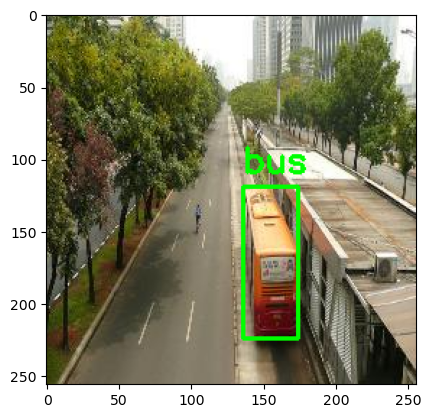

In [31]:
def get_dataset(path, debug=False):
    # Constants
    transform = tvt.Compose([tvt.ToTensor(), tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Create PyTorch Datasets and Dataloader
    df = pd.read_csv(path)
    dataset = GenerateDataset(df, transform)

    if(debug):
        x = dataset[2]
    return dataset

# Get Trainloader
train_dataset = get_dataset(path=r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw06/train_data.csv", debug=True)

In [33]:
# Get Trainloader
train_dataset = get_dataset(path=r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw06/train_data.csv", debug=True)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)

In [34]:
# Get Testloader
test_dataset = get_dataset(path=r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw06/train_data.csv", debug=True)
testloader = trainloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)

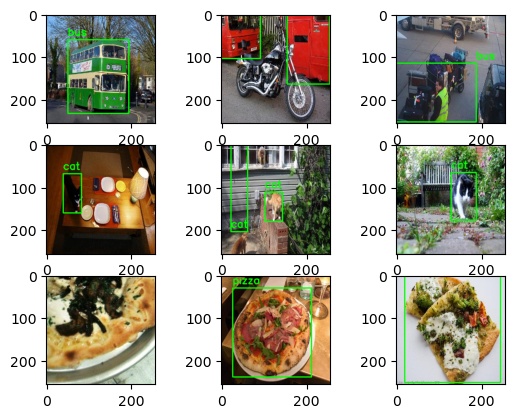

In [35]:
fig, ax = plt.subplots(3, 3)
def display_input_images_bbox(dataloader, label):
    row, col = class_list.index(label), 0
    for batch_idx, (images_in_batch, bbox_in_batch, labels_in_batch, _) in enumerate(dataloader):
        for idx in range(len(images_in_batch)):
            if(col < 3):
                # image shape: (3, 256, 256)
                image = np.asarray(tvt.ToPILImage()(images_in_batch[idx] / 2  + 0.5))

                # Labels
                labels_in_image = labels_in_batch[idx].tolist()
                valid_class_encoded_in_image = [inverse_categories[int(i)] for i in labels_in_image if int(i) != 13] # without 13

                # Bounding Box
                bboxs_in_image = bbox_in_batch[idx]
                valid_bboxs_in_image = []
                for object_bbox in bboxs_in_image:
                    if(object_bbox.tolist() != [0, 0, 0, 0]):
                        valid_bboxs_in_image.append(object_bbox.tolist())

                check = [False] * len(valid_bboxs_in_image)
                for jdx in range(len(valid_bboxs_in_image)):
                    if(valid_class_encoded_in_image[jdx] == label):
                        image = cv2.rectangle(image, (int(valid_bboxs_in_image[jdx][0]), int(valid_bboxs_in_image[jdx][1])), (int(valid_bboxs_in_image[jdx][2]), int(valid_bboxs_in_image[jdx][3])), color=(0,255,0), thickness=2)
                        image = cv2.putText(image, valid_class_encoded_in_image[jdx], (int(valid_bboxs_in_image[jdx][0]), int(valid_bboxs_in_image[jdx][1] - 10)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0,255,0), thickness=2)
                        check[jdx] = True

                if(sum(check)):
                    ax[row, col].imshow(image)
                    col += 1

display_input_images_bbox(trainloader, "bus")
col = 0
display_input_images_bbox(trainloader, "cat")
col = 0
display_input_images_bbox(trainloader, "pizza")

## The Deep Neural Network

In [8]:
class SkipBlock(nn.Module):
    # Inspired by Professor Kak's SkipBlock class
    def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
        super(SkipBlock, self).__init__()
        self.downsample = downsample
        self.skip_connections = skip_connections
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.conv1 = nn.Conv2d(self.in_ch, self.out_ch, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.in_ch, self.out_ch, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(self.out_ch)
        
        if(downsample):
            self.downsampler = nn.Conv2d(self.in_ch, self.out_ch, kernel_size=1, stride=2)
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn(out)
        out = F.relu(out)
        if(self.in_ch == self.out_ch):
            out = self.conv2(out)
            out = self.bn(out)
            out = F.relu(out)
        if(self.downsample):
            out = self.downsampler(out)
            identity = self.downsampler(identity)
        if(self.skip_connections):
            if(self.in_ch == self.out_ch):
                out = out + identity
            else:
                out = torch.cat((out[:,:self.in_ch,:,:] + identity, out[:, self.in_ch:, :, :] + identity), dim=1)
        return out

In [9]:
class NetForYolo(nn.Module):
    # Inspired by Professor Kak's NetForYolo class
    def __init__(self, skip_connections=True, depth=8):
        super(NetForYolo, self).__init__()
        self.skip_connections = skip_connections
        self.depth = depth // 2
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=128)
        # self.bn3 = nn.BatchNorm2d(num_features=256)
        self.skip64_arr = nn.ModuleList()
        for idx in range(self.depth):
            self.skip64_arr.append(SkipBlock(in_ch=64, out_ch=64, skip_connections=self.skip_connections))
        
        self.skip64ds = SkipBlock(in_ch=64, out_ch=64, downsample=True, skip_connections=self.skip_connections)
        self.skip64to128 = SkipBlock(in_ch=64, out_ch=128, skip_connections=self.skip_connections)
        self.skip128_arr = nn.ModuleList()
        for idx in range(self.depth):
            self.skip128_arr.append(SkipBlock(in_ch=128, out_ch=128, skip_connections=self.skip_connections))
        
        self.skip128ds = SkipBlock(in_ch=128, out_ch=128, downsample=True, skip_connections=self.skip_connections)
        # self.skip128to256 = SkipBlock(in_ch=128, out_ch=256, skip_connections=self.skip_connections)
        # self.skip256_arr = nn.ModuleList()
        # for idx in range(self.depth):
        #     self.skip256_arr.append(SkipBlock(in_ch=256, out_ch=256, skip_connections=self.skip_connections))
        
        # self.skip256ds = SkipBlock(in_ch=256, out_ch=256, downsample=True, skip_connections=self.skip_connections)
        self.fc_seqn = nn.Sequential(
            nn.Linear(in_features=128*16*16, out_features=6*6*5*9),
#             nn.ReLU(inplace=True),
#             nn.Linear(in_features=4096, out_features=2048),
#             nn.ReLU(inplace=True),
#             nn.Linear(in_features=2048, out_features=6*6*5*9) # 6x6 grid overlaying the image, 5 anchor boxes, length 9 yolo vector
        )

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        for idx, skip64 in enumerate(self.skip64_arr[:self.depth//4]):
            x = skip64(x)
        x = self.skip64ds(x)
        for idx, skip64 in enumerate(self.skip64_arr[:self.depth//4]):
            x = skip64(x)
        x = self.bn1(x)
        x = self.skip64to128(x)
        for idx, skip128 in enumerate(self.skip128_arr[:self.depth//4]):
            x = skip128(x)
        x = self.bn2(x)
        x = self.skip128ds(x)
        x = x.view(-1, 128*16*16)
        x = self.fc_seqn(x)
        return x
                                   

In [10]:
# Number of layers and learnable parameters
net = NetForYolo(skip_connections=True, depth=8)
num_layers = len(list(net.parameters()))
num_learnable_parameters = sum(p.numel() for p in net.parameters() if p.requires_grad)

print(f"Number of layers in the network: {num_layers}")
print(f"Number of learnable parameters in the network: {num_learnable_parameters}")
summary(net, input_size=(batch_size, 3, image_size, image_size))

Number of layers in the network: 80
Number of learnable parameters in the network: 55140564


Layer (type:depth-idx)                   Output Shape              Param #
NetForYolo                               [2, 1620]                 221,952
├─Conv2d: 1-1                            [2, 64, 256, 256]         1,792
├─MaxPool2d: 1-2                         [2, 64, 128, 128]         --
├─Conv2d: 1-3                            [2, 64, 128, 128]         36,928
├─MaxPool2d: 1-4                         [2, 64, 64, 64]           --
├─ModuleList: 1-7                        --                        (recursive)
│    └─SkipBlock: 2-1                    [2, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [2, 64, 64, 64]           36,928
│    │    └─BatchNorm2d: 3-2             [2, 64, 64, 64]           128
│    │    └─Conv2d: 3-3                  [2, 64, 64, 64]           36,928
│    │    └─BatchNorm2d: 3-4             [2, 64, 64, 64]           (recursive)
├─SkipBlock: 1-6                         [2, 64, 32, 32]           --
│    └─Conv2d: 2-2                       [2, 6

## Training

In [11]:
# Parameters to train the network
net = NetForYolo(skip_connections=True, depth=8)
lr = 1e-6
betas = (0.9, 0.99)
epochs = 12
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=betas)
criterion1 = nn.BCELoss() # For the first element of the yolo vector, check whether a true bbox was assigned or not
criterion2 = nn.MSELoss() # For the next four elements of the yolo vector, corresponding to the bounding box
criterion3 = nn.CrossEntropyLoss() # For the last three elements of the yolo vector, corresponding to the one hot encoding of label

In [12]:
def train(net, trainloader):
    # Inspired by Professor Kak's run_code_for_training_multi_instance_detection function
    net = net.to(device)
    presence_average_loss = []
    regression_average_loss = []
    class_average_loss = []

    print("Training started")

    for epoch in range(1, epochs + 1):
        print(f"Epoch: {epoch} / {epochs}")
        running_bce_loss = 0.0
        running_mse_loss = 0.0
        running_ent_loss = 0.0

        for batch_idx, (images_in_batch, _, _, yolo_tensors_in_batch) in enumerate(trainloader):
            images_in_batch = images_in_batch.to(device)
            yolo_tensors_in_batch = yolo_tensors_in_batch.to(device)

            optimizer.zero_grad()
            output = net(images_in_batch)    
            # print(output.shape)                                                                           
            output = output.view(batch_size, num_yolo_cells, num_anchor_boxes, yolo_vector_size+1)
            
            total_bce_loss = torch.tensor(0.0, requires_grad=True).float().to(device)
            total_mse_loss = torch.tensor(0.0, requires_grad=True).float().to(device)
            total_ent_loss = torch.tensor(0.0, requires_grad=True).float().to(device)

            # Get Yolo Vectors where object presence is not zero
            object_presence = torch.nonzero(output[:, :, :, 0])
            
            # Compute BCE Loss
            sigmoid = nn.Sigmoid()
            bce_loss = criterion1(sigmoid(output[:, :, :, 0]), yolo_tensors_in_batch[:, :, :, 0])
            total_bce_loss += bce_loss
            
            # Compute Regression Loss
            predicted_regression_vector = output[object_presence[:,0], object_presence[:,1], object_presence[:,2], 1:5]
            target_regression_vector = yolo_tensors_in_batch[object_presence[:,0], object_presence[:,1], object_presence[:,2], 1:5]
            mse_loss = criterion2(predicted_regression_vector, target_regression_vector)
            total_mse_loss += mse_loss
            
            # Compute Cross Entropy Loss
            class_probs_vector = output[object_presence[:,0], object_presence[:,1], object_presence[:,2], 5:-1]
            target_class_vector = torch.argmax(yolo_tensors_in_batch[object_presence[:,0], object_presence[:,1], object_presence[:,2], 5:-1], dim=1)
            cross_loss = criterion3(class_probs_vector, target_class_vector)
            total_ent_loss += cross_loss
            
            total_ent_loss.backward(retain_graph=True)
            total_mse_loss.backward(retain_graph=True)
            total_bce_loss.backward(retain_graph=True)
            
            optimizer.step()

            running_bce_loss += total_bce_loss.item()
            running_mse_loss += total_mse_loss.item()
            running_ent_loss += total_ent_loss.item()


            if(batch_idx % 20 == 19):
                print(f"[Epoch: {epoch}/{epochs}, Batch Idx= {batch_idx + 1}] ------- Average BCE Loss: {running_bce_loss / float(20)}, Average MSE Loss: {running_mse_loss / float(20)}, Average Cross Entropy Loss: {running_ent_loss / float(20)}")
                
                presence_average_loss.append(running_bce_loss / float(20))
                regression_average_loss.append(running_mse_loss / float(20))
                class_average_loss.append(running_ent_loss / float(20))
                
                torch.save(net.state_dict(), path_to_model)
                
                running_bce_loss = 0.0
                running_mse_loss = 0.0
                running_ent_loss = 0.0

    return presence_average_loss, regression_average_loss, class_average_loss   

presence_loss, regression_loss, class_loss = train(net, trainloader)

Training started
Epoch: 1 / 12
[Epoch: 1/12, Batch Idx= 20] ------- Average BCE Loss: 0.6821336805820465, Average MSE Loss: 0.204831712692976, Average Cross Entropy Loss: 1.0963958561420442
[Epoch: 1/12, Batch Idx= 40] ------- Average BCE Loss: 0.6461931467056274, Average MSE Loss: 0.19594565406441689, Average Cross Entropy Loss: 0.9951253563165665
[Epoch: 1/12, Batch Idx= 60] ------- Average BCE Loss: 0.6141113638877869, Average MSE Loss: 0.1963033437728882, Average Cross Entropy Loss: 0.9048535227775574
[Epoch: 1/12, Batch Idx= 80] ------- Average BCE Loss: 0.5765013545751572, Average MSE Loss: 0.19301662743091583, Average Cross Entropy Loss: 0.8141756653785706
[Epoch: 1/12, Batch Idx= 100] ------- Average BCE Loss: 0.5452347874641419, Average MSE Loss: 0.18130092769861222, Average Cross Entropy Loss: 0.7422182708978653
[Epoch: 1/12, Batch Idx= 120] ------- Average BCE Loss: 0.5153367340564727, Average MSE Loss: 0.1806643471121788, Average Cross Entropy Loss: 0.672001588344574
[Epoch

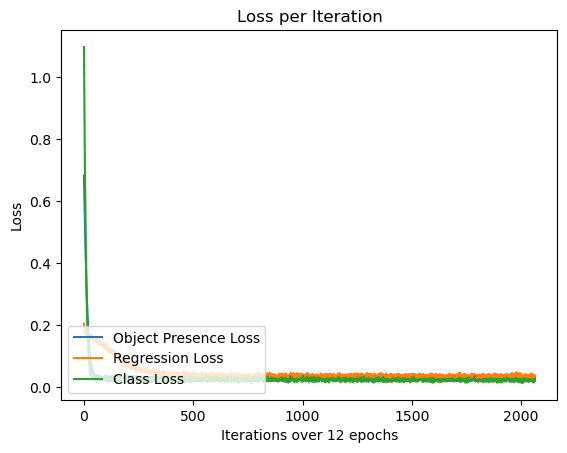

In [13]:
def plot_losses(presence_loss, regression_loss, class_loss):
    assert len(presence_loss) == len(regression_loss) == len(class_loss)

    iterations = range(len(presence_loss))
    figure = plt.figure(1)
    plt.plot(iterations, presence_loss, label="Object Presence Loss")
    plt.plot(iterations, regression_loss, label="Regression Loss")
    plt.plot(iterations, class_loss, label="Class Loss")

    plt.title(f"Loss per Iteration")
    plt.xlabel(f"Iterations over {epochs} epochs")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    
    filename = "train_loss.jpg"
    plt.savefig(os.path.join("/scratch/gilbreth/dfarache/ece60146/Nikita/hw06/Results", filename))
    plt.show()

plot_losses(presence_loss, regression_loss, class_loss)

## Testing

In [20]:
def display_confusion_matrix(confusion_matrix):
    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
    figure = plt.figure(2)
    sns.heatmap(confusion_matrix, xticklabels=class_list, yticklabels=class_list, annot=True)
    plt.xlabel(f"True Label \n Accuracy: {accuracy}")
    plt.ylabel("Predicted Label")

    filename = "conf.jpg"
    plt.savefig(os.path.join("/scratch/gilbreth/dfarache/ece60146/Nikita/hw06/Results", filename))
    plt.show()

In [15]:
def get_best_class_index(class_labels_probs):
    best_predicted_class_index = (class_labels_probs == class_labels_probs.max())
    best_predicted_class_index = torch.nonzero(best_predicted_class_index, as_tuple=True)
    predicted_class_label = class_list[best_predicted_class_index[0].item()]

    return predicted_class_label

In [16]:
def analyze_regression_elements(icx, predicted_regression_vector):
    del_x,del_y = predicted_regression_vector[0], predicted_regression_vector[1]
    h,w = predicted_regression_vector[2], predicted_regression_vector[3]
    h *= yolo_interval
    w *= yolo_interval       
    
    cell_row_index =  icx // num_cells_image_height
    cell_col_index =  icx % num_cells_image_width
    
    bbox_center_x_coord = cell_col_index * yolo_interval  +  yolo_interval/2  +  del_x * yolo_interval
    bbox_center_y_coord = cell_row_index * yolo_interval  +  yolo_interval/2  +  del_y * yolo_interval
    x1 =  int(bbox_center_x_coord - w / 2.0)
    y1 =  int(bbox_center_y_coord - h / 2.0)
    
    return [x1, y1, int(w + x1), int(h + y1)]

In [17]:
def test(net, testloader, num_classes=3, debug=False):
    count = 0
    # Inspired by Professor Kak's run_code_for_testing_multi_instance_detection function
    net.load_state_dict(torch.load(path_to_model))
    net = net.to(device)
    confusion_matrix = np.zeros((num_classes, num_classes))
    correct, total = 0,0

    with torch.no_grad():
        for batch_idx, (images_in_batch, bboxs_in_batch, labels_in_batch, yolo_tensors_in_batch) in enumerate(testloader):
            images_in_batch = images_in_batch.to(device)
            bboxs_in_batch = bboxs_in_batch.to(device)
            labels_in_batch = labels_in_batch.to(device)
            yolo_tensors_in_batch = yolo_tensors_in_batch.to(device)
            
            output = net(images_in_batch)
            output = output.view(batch_size, num_yolo_cells, num_anchor_boxes, yolo_vector_size+1)
            
            if(debug):
                print(f"Output Shape: {output.shape}")

            for ibx in range(output.shape[0]): # Across batch axis
#                 print(f"Batch Idx: {batch_idx}, Image Number in Batch: {ibx + 1}")
                # Look through all the cells and identify at most five of the cells/anchor_boxes for the value in the first element of the predicted yolo_vectors is the highest
                # Determine if the anchorbox and cell have an object or not
                icx_to_best_anchor_box = {ic: None for ic in range(num_cells_image_height * num_cells_image_width)}
                for icx in range(output.shape[1]): # Across yolo cell axis
                    cell_predictions = output[ibx, icx]
                    previous_best = 0
                    for iax in range(cell_predictions.shape[0]):
                        if(debug):
                            print(f"Cell Predictions at Index [iax, 0] shape: {cell_predictions[iax][0].shape}")
                        if(cell_predictions[iax][0] > cell_predictions[previous_best][0]):
                            previous_best = iax
                    icx_to_best_anchor_box[icx] = previous_best
                
                # Get the 5 yolo cells with the best anchor boxes that have an object
                sorted_icx_to_box = sorted(icx_to_best_anchor_box, 
                                key=lambda x: output[ibx,x,icx_to_best_anchor_box[x]][0].item(), reverse=True)
                retained_cells = sorted_icx_to_box[:5]
            
                # Identify the objects in the retained cells and extract their bounding boxes
                predicted_bboxs = []
                predicted_labels = []

                for icx in retained_cells:
                    predicted_yolo_vector = output[ibx, icx, icx_to_best_anchor_box[icx]]
                    target_yolo_vector = yolo_tensors_in_batch[ibx, icx, icx_to_best_anchor_box[icx]]

                    if(debug):
                        print(f"Predicted yolo vector: {predicted_yolo_vector}")
                        print(f"Target yolo vector: {target_yolo_vector}")

                    class_label_predictions = predicted_yolo_vector[-4:]
                    class_labels_probs = torch.nn.Softmax(dim=0)(class_label_predictions)
                    class_labels_probs = class_labels_probs[:-1]
                    if(torch.all(class_labels_probs < 0.1)):
                        predicted_class_label = None

                    else:
                        # Get the predicted class label
                        predicted_class_label = get_best_class_index(class_labels_probs)
                        predicted_labels.append(predicted_class_label)

                        # Analyze the predicted regression elements
                        predicted_regression_vector = predicted_yolo_vector[1:5].cpu()
                        pred_bb = analyze_regression_elements(icx, predicted_regression_vector)
                        predicted_bboxs.append(pred_bb)
                    
                # Confusion Matrix
                for gt, pred in zip(labels_in_batch[ibx], predicted_labels):
                    if(int(gt) != 13):
                        gt_label = inverse_categories[int(gt)]
                        confusion_matrix[int(gt)][class_list.index(pred)] += 1
                
        
                if((batch_idx + 1) % 50 == 0 and count < 8): 
                    if(predicted_bboxs and predicted_labels):
                        image_gt = np.asarray(tvt.ToPILImage()(images_in_batch[ibx] / 2  + 0.5))
                        image_pred = np.asarray(tvt.ToPILImage()(images_in_batch[ibx] / 2  + 0.5))
                        fig, axes = plt.subplots(1, 2)

                        ## Ground Truth
                        # Labels
                        labels_in_image = labels_in_batch[ibx].tolist()
                        valid_class_encoded_in_image = [inverse_categories[int(i)] for i in labels_in_image if int(i) != 13] # without 13
                        print(f"Ground Truth: {valid_class_encoded_in_image}")

                        # Bounding Box
                        bboxs_in_image = bboxs_in_batch[ibx]
                        valid_bboxs_in_image = []
                        for object_bbox in bboxs_in_image:
                            if(object_bbox.tolist() != [0, 0, 0, 0]):
                                valid_bboxs_in_image.append(object_bbox.tolist())

                        for jdx in range(len(valid_bboxs_in_image)):
                            image_gt = cv2.rectangle(image_gt, (int(valid_bboxs_in_image[jdx][0]), int(valid_bboxs_in_image[jdx][1])), (int(valid_bboxs_in_image[jdx][2]), int(valid_bboxs_in_image[jdx][3])), color=(0,255,0), thickness=2)
                            image_gt = cv2.putText(image_gt, valid_class_encoded_in_image[jdx], (int(valid_bboxs_in_image[jdx][0]), int(valid_bboxs_in_image[jdx][1] - 10)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0,255,0), thickness=2)

                        axes[0].imshow(image_gt)

                        ## Predicted
                        print(f"Predicted: {predicted_labels}")
                        for jdx in range(len(predicted_bboxs)):
                            image_pred = cv2.rectangle(image_pred, (int(predicted_bboxs[jdx][0]), int(predicted_bboxs[jdx][1])), (int(predicted_bboxs[jdx][2]), int(predicted_bboxs[jdx][3])), color=(0,255,0), thickness=2)
                            image_pred = cv2.putText(image_pred, predicted_labels[jdx], (int(predicted_bboxs[jdx][0]), int(predicted_bboxs[jdx][1] - 10)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0,255,0), thickness=2)

                        axes[1].imshow(image_pred)
                        count += 1

    return confusion_matrix

Ground Truth: ['cat']
Predicted: ['bus', 'bus', 'bus', 'bus', 'bus']
Ground Truth: ['pizza', 'pizza']
Predicted: ['bus', 'bus', 'bus', 'bus', 'bus']
Ground Truth: ['cat', 'cat']
Predicted: ['bus', 'bus', 'bus', 'bus', 'bus']
Ground Truth: ['pizza']
Predicted: ['bus', 'bus', 'bus', 'bus', 'bus']
Ground Truth: ['cat']
Predicted: ['bus', 'bus', 'bus', 'bus', 'bus']
Ground Truth: ['cat']
Predicted: ['bus', 'bus', 'bus', 'bus', 'bus']
Ground Truth: ['cat', 'cat']
Predicted: ['bus', 'bus', 'bus', 'bus', 'bus']
Ground Truth: ['pizza']
Predicted: ['bus', 'bus', 'bus', 'bus', 'bus']


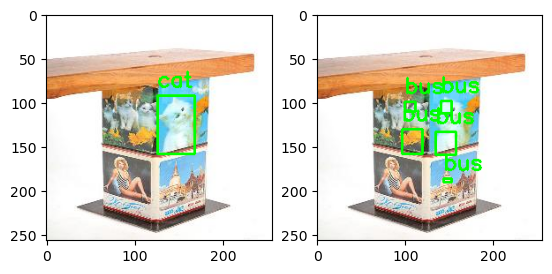

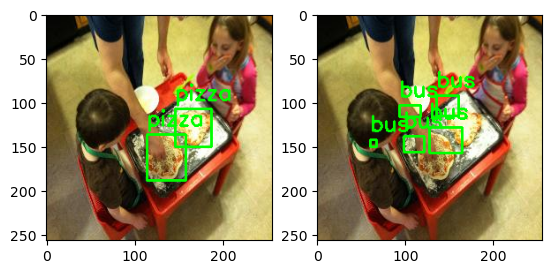

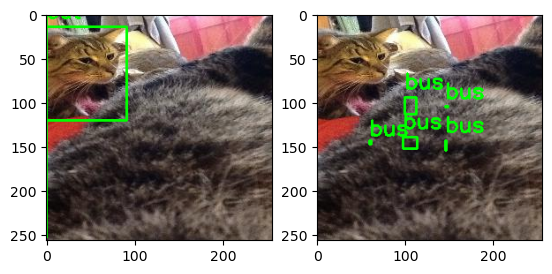

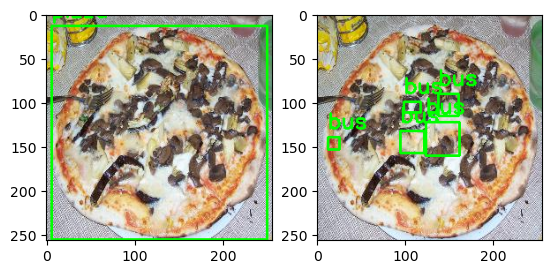

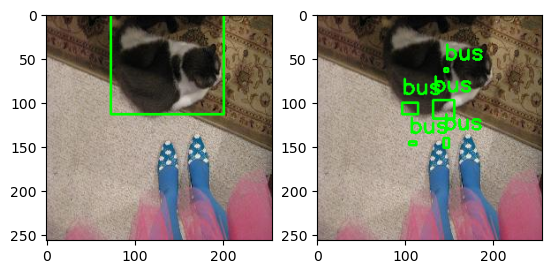

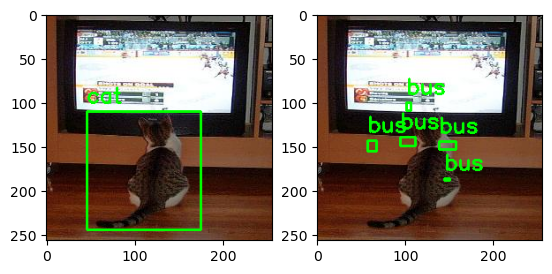

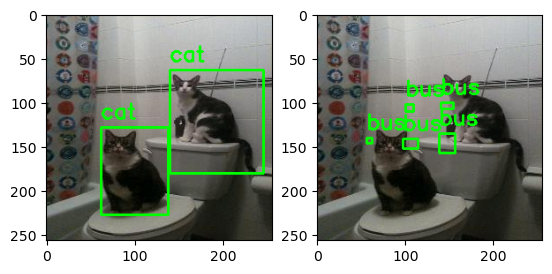

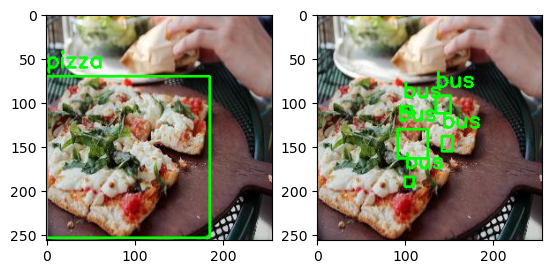

In [18]:
# Experimenting with testloader
test_confusion_matrix = test(net, testloader, num_classes=3, debug=False)

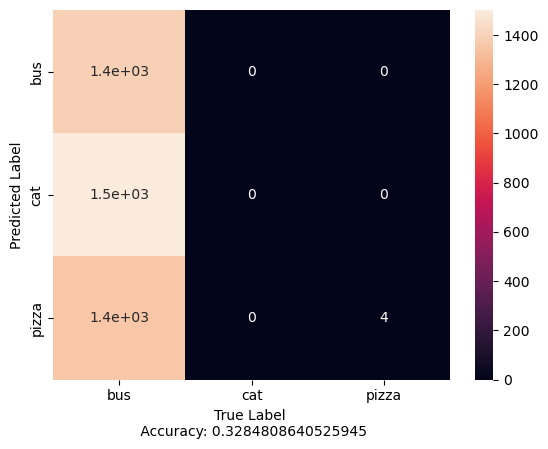

In [21]:
display_confusion_matrix(test_confusion_matrix)